In [1]:
from langchain_community.document_loaders import DirectoryLoader, TextLoader

/home/md-al-amin/My-Projects/Data2llm-16-Personality-MBTI-Prediction-Pipeline-RAG-LoRA/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# loader = DirectoryLoader(
#     path="processed/",
#     glob="**/*.txt",           # recursive load of all txt files
#     loader_cls=TextLoader,     # use TextLoader for each file
#     show_progress=True
# )

# documents = loader.load()
# print(f"Loaded {len(documents)} text documents.")

import re
from langchain_community.document_loaders import DirectoryLoader, TextLoader

def extract_name_from_text(text):
    match = re.search(r"Name:\s*(.+)", text)
    if match:
        return match.group(1).strip()
    return "Unknown"

# Load all .txt files
loader = DirectoryLoader(
    "processed/",
    glob="*.txt",
    loader_cls=TextLoader,
    show_progress=True,
)
documents = loader.load()

# Add metadata: "name"
for doc in documents:
    name = extract_name_from_text(doc.page_content)
    doc.metadata["name"] = name


100%|██████████| 14/14 [00:00<00:00, 8799.68it/s]


In [3]:
documents[1]

Document(metadata={'source': 'processed/abdullahjashim06_posts.txt', 'name': 'Abdullah Jashim'}, page_content="Name: Abdullah Jashim\nHeadline: Mechanical Process Development Engineer | Chemical Engineer | Lean Six Sigma Practitioner | Process Improvement Strategist | Research and Innovation Enthusiast\nLocation: Dhaka, Bangladesh\nCurrent Company: Walton Hi-Tech Industries PLC.\n\nAbout: As a versatile chemical engineer, I have had the opportunity to work in various fields that have significantly broadened my skill set and expertise. My professional journey spans manufacturing of:\nAir-conditioner, Caustic Soda and Fertilizer\n#Strengths:\na. Analytical Thinking:\nAcross all roles, I have been responsible for analyzing data, identifying patterns, and deriving actionable insights. Whether it's optimizing a chemical process or troubleshooting a production issue, my ability to think critically and base decisions on data has been integral to my success. This analytical approach has been e

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

In [6]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)


In [7]:
llm.invoke("Test line")

AIMessage(content='Test line received.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--131e841f-a063-41d3-a3e0-bc3222842820-0', usage_metadata={'input_tokens': 3, 'output_tokens': 31, 'total_tokens': 34, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 27}})

In [8]:
embed_len = len(embeddings.embed_query("Hello"))
embed_len

768

In [9]:
import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore

In [10]:
index = faiss.IndexFlatL2(768)

In [11]:
## create VectorStore

AAladinVectorStore = FAISS(
    index=index,
    embedding_function=embeddings,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={}
    
)

In [12]:
AAladinVectorStore.add_documents(documents=documents)

['020f7941-4fa8-467a-928d-065b428bef32',
 'd603d3a9-debf-452b-b07b-bc1d18029e62',
 '2252a0dd-b441-4fff-af68-0bd85d5a947a',
 'cf8ccea8-55f4-4f69-afe6-b2f3bde4f813',
 'd57d0ee7-7c65-4289-ab87-b4655fc216ff',
 '095e5957-98dd-4cc1-a96c-0caf3dcf2d69',
 '0a4b7a06-3303-410a-89c3-789eb0b18665',
 '7b15fefa-7f82-461b-8b01-d1644666e251',
 'fc22053c-fd4e-43e2-835f-39d88a97fa21',
 '709933bc-8623-4dc7-b43e-e3bde4179ae4',
 '7d06cb13-6be6-4a38-84d8-741b0555b46b',
 '77b95aff-693b-4183-b188-5c07cf6fac8d',
 '84f4b23d-c445-4e3e-882b-0153adc3bdab',
 '2415c687-81ba-4089-ba24-719f62538464']

In [13]:
AAladinVectorStore.similarity_search("Al Amin", k=1, filter={"name": "Al Amin"})

[Document(id='cf8ccea8-55f4-4f69-afe6-b2f3bde4f813', metadata={'source': 'processed/mdalamin5_posts.txt', 'name': 'Al Amin'}, page_content='Name: Al Amin\nHeadline: Generative AI Engineer | LangChain, LangGraph & RAG | Building intelligent multi-agent systems.\nLocation: Dhaka, Bangladesh\nCurrent Company: Genuine Technology & Research Ltd.\n\nAbout: A dedicated Computer Science student at Dhaka University with hands-on experience architecting and building end-to-end Generative AI applications. My passion lies in creating intelligent agents that can reason, remember, and interact naturally.\n\nTop Skills: Retrieval-Augmented Generation (RAG), AI Agents, Python (Programming Language)\n\nFeatured Section:\n\nExperience:\n- Generative AI Engineer at Genuine Technology & Research Ltd. (Full-time, May 2025 - Present, Dhaka, Bangladesh): Developing and deploying multi-agent systems using LangChain and LangGraph.\n\nEducation:\n- B.Sc in Computer Science from Dhaka University (2020 - 2024, Gr

In [14]:
search_name = "Al Amin"

In [19]:
retriever = AAladinVectorStore.as_retriever(
    search_kwargs={"k": 5, "filter": {"name": search_name}}
)


## Name Extractions

In [78]:
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from dotenv import load_dotenv

load_dotenv()

# Example LLM (replace with your actual model)
# name_llm = ChatGroq(model_name="qwen/qwen3-32b")

class UserNameExtract(BaseModel):
    """This class is designed for user name extraction from the user input."""
    user_name: str = Field(
        description=(
            "Extract the user name from the user input. "
            "If the name is not found, simply return 'unknown'. "
            "Example: 'Tell me about Al Amin infos' -> user_name: 'Al Amin'"
        )
    )

# Wrap your LLM with structured output
llm_with_str_output = llm.with_structured_output(UserNameExtract)

# Use invoke_and_parse() to get a Pydantic object
result = llm_with_str_output.invoke("Tell me about Al Amin infos.")

print(result.user_name)


Al Amin


In [20]:
retriever.invoke("Tell me about Al Amin")

[Document(id='cf8ccea8-55f4-4f69-afe6-b2f3bde4f813', metadata={'source': 'processed/mdalamin5_posts.txt', 'name': 'Al Amin'}, page_content='Name: Al Amin\nHeadline: Generative AI Engineer | LangChain, LangGraph & RAG | Building intelligent multi-agent systems.\nLocation: Dhaka, Bangladesh\nCurrent Company: Genuine Technology & Research Ltd.\n\nAbout: A dedicated Computer Science student at Dhaka University with hands-on experience architecting and building end-to-end Generative AI applications. My passion lies in creating intelligent agents that can reason, remember, and interact naturally.\n\nTop Skills: Retrieval-Augmented Generation (RAG), AI Agents, Python (Programming Language)\n\nFeatured Section:\n\nExperience:\n- Generative AI Engineer at Genuine Technology & Research Ltd. (Full-time, May 2025 - Present, Dhaka, Bangladesh): Developing and deploying multi-agent systems using LangChain and LangGraph.\n\nEducation:\n- B.Sc in Computer Science from Dhaka University (2020 - 2024, Gr

In [ ]:


rag_prompt = """
You are a professional text-processing agent in a Retrieval-Augmented Generation (RAG) system. 
Your goal is to extract, elaborate, and preserve psychologically relevant signals from the user's professional profile and social media posts.

The downstream model is a fine-tuned personality prediction model (trained on the MITB dataset),
so you must generate a detailed, context-rich text that mirrors the user's authentic communication style and thought patterns.

## User Question
{question}

### INPUT
{context}

### TASK
Generate an **elaborated personality-relevant summary** that:
- Starts by clearly stating the user's name.
- Retains the user's tone, reasoning style, values, and emotional patterns.
- Expands slightly on ideas to create a coherent narrative while staying faithful to the text.
- Keeps important sentences or quotes from posts intact (don’t heavily compress them).
- Merges the profile and posts naturally, as if describing one person’s mindset and communication identity.
- Avoids lists, hashtags, or bullet points unless they were part of the original content.

### OUTPUT FORMAT
Return a plain text string in the following structure:

Username: <user's name>

Profile Summary:
<expanded, narrative description of the user's professional and personal profile>

Post Summary:
<detailed, elaborated synthesis of the user's posts, preserving reasoning, tone, and emotional cues>

### STYLE REQUIREMENTS
- Output should be detailed (approx. 1200–2000 tokens).
- Preserve natural tone — don’t make it robotic or overly summarized.
- Absolutely avoid speculative or made-up information.
- The output will be passed directly into a personality prediction LLM, so keep the style **raw, human-like, and content-rich.**
"""



In [47]:
from langchain_core.output_parsers import StrOutputParser

In [48]:
from langchain_core.runnables import RunnablePassthrough

def format_docs(retriever_docs):
    context_text = "\n\n".join(doc.page_content for doc in retriever_docs)
    return context_text

In [49]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

# Prompt Template
rag_prompt_template = PromptTemplate(
    input_variables=["context", "question"],
    template=rag_prompt
)

# RAG Chain
rag_chain = (
    {
        "context": retriever,
        "question": RunnablePassthrough()
    }
    | rag_prompt_template
    | llm
    | StrOutputParser()  # outputs a clean string
)


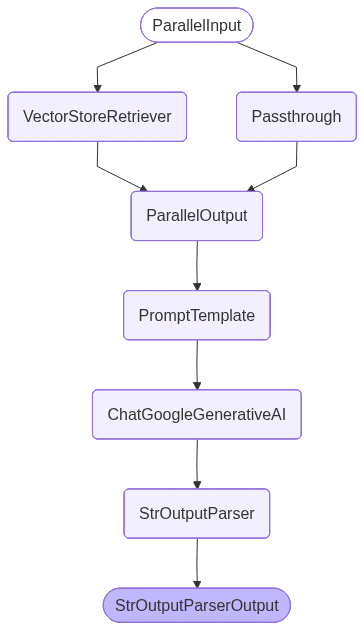

In [50]:
from IPython.display import display, Image
display(Image(rag_chain.get_graph().draw_mermaid_png()))

In [51]:
user_query = "Tell ABout the md al amin profession summary."

result = rag_chain.invoke(user_query)
print(result)


Username: Al Amin

Profile Summary:
Al Amin presents himself as a dedicated Generative AI Engineer, specializing in LangChain, LangGraph, and Retrieval-Augmented Generation (RAG), with a clear focus on "building intelligent multi-agent systems." Based in Dhaka, Bangladesh, he is currently contributing his expertise at Genuine Technology & Research Ltd. His academic foundation is robust, having pursued a B.Sc in Computer Science at Dhaka University, where he achieved an impressive CGPA of 3.80/4. This strong academic performance is consistent throughout his education, including a perfect GPA of 5.00/5 in both his H.S.C from Dhaka College and S.S.C from Dhaka Residential Model College. His "About" section reveals a profound passion for "architecting and building end-to-end Generative AI applications," driven by a desire to create "intelligent agents that can reason, remember, and interact naturally." His top skills, explicitly listed as Retrieval-Augmented Generation (RAG), AI Agents, an

In [52]:
# import json
# data = json.loads(result)
# data

## **Name Extractions from User input"**

In [ ]:
from pydantic import BaseModel, Field
from typing import Annotated
from langchain_groq import ChatGroq
load_dotenv()


# name_llm = ChatGroq(model_name = "qwen/qwen3-32b")

class UserNameExtract(BaseModel):
    """This class is designed for user name extract from the user input."""
    user_name: str = Field(description="Extract the user name from the user input. if name not found the simply say 'unknown'")

# llm_with_str_output = name_llm.with_structured_output(UserNameExtract)
llm_with_str_output = llm.with_structured_output(UserNameExtract)

llm_with_str_output.invoke("Tell me about Sharier Choudhori infos.")


UserNameExtract(user_name='Sharier Choudhori')

In [56]:
llm_with_str_output.invoke("Tell me about Al Aamin infos.")

UserNameExtract(user_name='unknown')